# Projeto Final Redes Neurais

<b> Grupo: </b> João Otávio de Ávila Nascimento, Emelyn Alves e Kayllanny Lara da Silva Oliveira
\
<b> Professor: </b> Daniel Cassar

Inicialmente, realizamos a importação de todas as bibliotecas necessárias para o funcionamento do código, garantindo que todas as dependências e ferramentas essenciais estejam disponíveis para execução correta e eficiente do programa.

In [11]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import optuna
import lightning as L

ModuleNotFoundError: No module named 'lightning'

Após as importações, carregamos nosso dataset, que é um conjunto de dados sintéticos do setor agrícola. Ele relaciona o rendimento em kg por hectare com a qualidade do solo, a variedade das sementes, a quantidade de fertilizante por hectare em kg, a quantidade de dias de sol, de precipitação em mm e os horários de irrigação. Esses dados são importantes, pois permitem prever a colheita de acordo com as condições e identificar as condições ideais para o crescimento das lavouras.

In [3]:
features = ['Soil_Quality', 'Seed_Variety', 'Fertilizer_Amount_kg_per_hectare', 'Sunny_Days', 'Rainfall_mm', 'Irrigation_Schedule']
target = ['Yield_kg_per_hectare']

df_teste = pd.read_csv("agricultural_yield_test.csv")
df_treino = pd.read_csv("agricultural_yield_train.csv")

df_teste = df_teste.reindex(features + target, axis=1)
df_teste = df_teste.dropna()

df_treino = df_treino.reindex(features + target, axis=1)
df_treino = df_treino.dropna()

Aqui, separamos os atributos dos alvos. Como os dados de treino e teste já vieram separados, apenas os carregamos em suas respectivas variáveis, removemos os valores ausentes e imprimimos as variáveis a seguir.

In [4]:
df_teste

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,93.304721,0,132.522218,96.670922,602.386237,3,278.986563
1,83.674653,1,57.283997,99.007556,466.518251,8,836.434840
2,65.963033,1,227.895479,104.844272,510.320495,4,785.881787
3,78.692834,1,176.314126,90.136191,354.350914,5,807.884526
4,72.415684,1,160.070418,101.221668,443.993788,10,1064.542374
...,...,...,...,...,...,...,...
3995,95.094714,1,124.108262,98.970659,496.705800,5,802.209345
3996,53.256984,0,100.310322,111.448947,667.056391,8,509.646540
3997,94.145522,1,196.473704,110.003474,458.241408,3,776.013634
3998,61.452120,1,80.618357,97.815517,778.652540,4,502.319484


In [5]:
df_treino

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,96.415657,1,147.853040,94.593926,444.267569,3,683.759119
1,92.352626,0,281.565396,90.504644,517.585491,7,678.714861
2,63.714785,1,137.864940,97.329340,420.310945,8,934.691975
3,90.084256,1,100.946659,113.404828,547.817646,7,905.842541
4,81.600341,1,223.088908,83.048176,434.726333,6,897.584665
...,...,...,...,...,...,...,...
15995,77.053550,1,154.189768,103.115855,319.915079,7,956.781949
15996,99.795631,1,282.295839,123.598354,647.292136,4,879.682714
15997,67.478487,1,120.017122,102.308627,514.372747,8,932.829561
15998,85.176890,1,247.847389,114.956634,695.035801,6,889.738438


Nesta célula, foi gerada uma matriz de correlação para observar a relação entre as colunas do dataset.

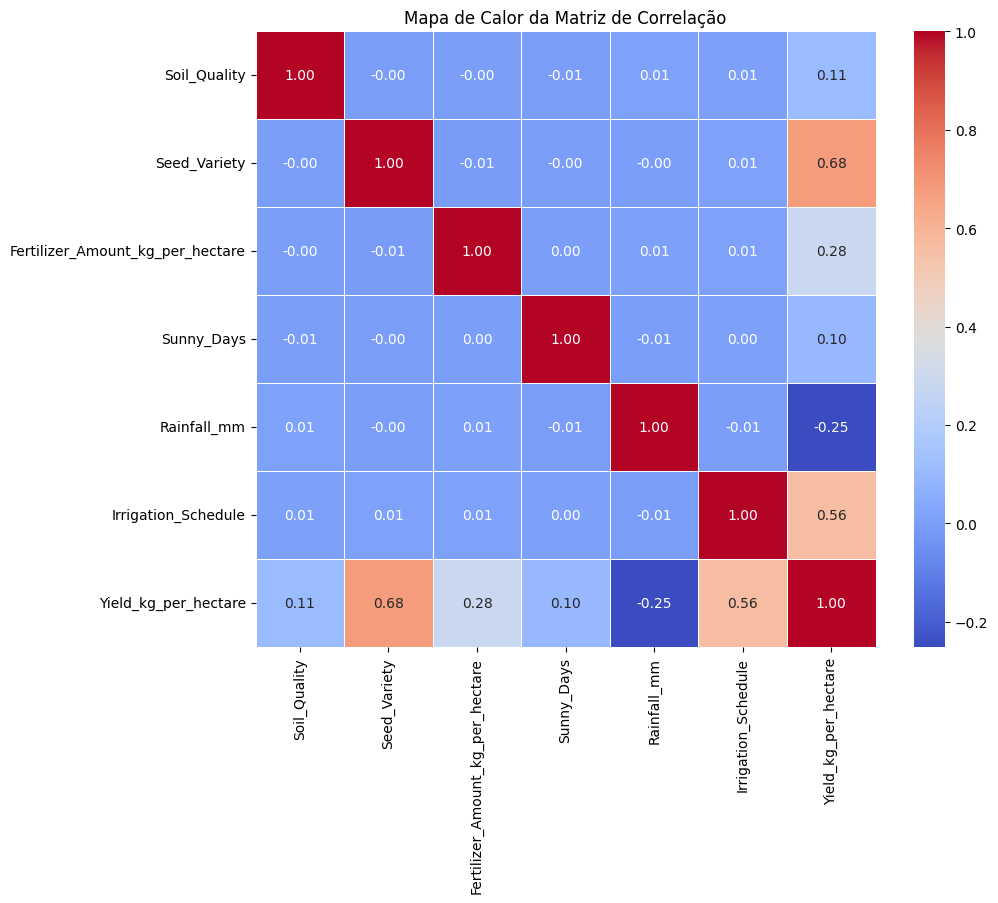

In [7]:
correlation_matrix = df_treino.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Calor da Matriz de Correlação')
plt.show()

Aqui estão os parâmetros da validação que serão utilizados posteriormente no código.

In [8]:
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 61455

Agora, finalmente, separamos os dados do dataset em alvo (target) e atributos.

In [9]:
X_teste = df_teste.reindex(features, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

Agora, dividimos o conjunto de treinamento em subconjuntos de treinamento e validação usando a técnica de divisão (split).

In [12]:
indices = df_treino.index
print(indices, len(indices))
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_VALIDACAO, random_state=SEMENTE_ALEATORIA
)

print(indices_treino, len(indices_treino))
print()
print(indices_val, len(indices_val))

df_val = df_treino.loc[indices_val]
df_treino = df_treino.loc[indices_treino]


X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

X_val = df_val.reindex(features, axis=1).values
y_val = df_val.reindex(target, axis=1).values

RangeIndex(start=0, stop=16000, step=1) 16000


NameError: name 'train_test_split' is not defined

Nas células de código abaixo, realizamos a normalização e a preparação dos dados para treinar e testar a rede neural.

In [ ]:
x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste)

In [ ]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

In [ ]:
X_teste

In [ ]:
y_teste

In [ ]:
X_treino

In [ ]:
y_treino

In [ ]:
X_val

In [ ]:
y_val

## Treinando a rede com uma arquitetura aleatória

In [ ]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
        )

In [ ]:
class MLP_teste(L.LightningModule):
    def __init__(
        self, num_dados_entrada, neuronios_c1, neuronios_c2, num_targets
    ):
        super().__init__()

        self.camadas = nn.Sequential(
            nn.Linear(num_dados_entrada, neuronios_c1),
            nn.Sigmoid(),
            nn.Linear(neuronios_c1, neuronios_c2),
            nn.Sigmoid(),
            nn.Linear(neuronios_c2, num_targets),
        )  
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
NUM_EPOCAS = 20

treinador = L.Trainer(max_epochs=NUM_EPOCAS)

Precisamos também criar uma instância da classe `DataModule` que definimos acima.



In [ ]:
dm = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

Antes de treinar, precisamos também criar uma instância da rede neural.



In [ ]:
num_dados_de_entrada = 6
num_dados_de_saida = 1
neuronios_c1 = random.randint(1, 120)
neuronios_c2 = random.randint(1, 120)

mlp_teste = MLP_teste(
    num_dados_de_entrada, neuronios_c1, neuronios_c2, num_dados_de_saida
)

Finalmente, temos tudo que precisamos. Podemos rodar o método `fit` do nosso treinador na nossa instância da rede neural, fornecendo também uma instância do `DataModule` como argumento.



In [ ]:
treinador.fit(mlp_teste, dm)

In [ ]:
figura, eixo = plt.subplots()

ca_treino = mlp_teste.curva_aprendizado_treino
ca_val = mlp_teste.curva_aprendizado_val

eixo.plot(ca_treino, label="Treino")
eixo.plot(ca_val, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

## Testando a rede com a arquitetura aleatória

Antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.



In [ ]:
minha_mlp.eval()

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [ ]:
dm.setup("test")

with torch.no_grad():
    X_true = dm.X_teste

    y_true = dm.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = minha_mlp(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

## Treinando diferentes MLPs

Hiperparâmetros: neurônios (cada camada), camadas e dropout.

In [ ]:
class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, num_targets, neuronios, dropouts
    ):
        super().__init__()    
        
        camadas = []   
        
        neuronios = [num_dados_entrada]+neuronios
    
        for k in range(len(neuronios)-1):
            camadas.append(nn.Linear(neuronios[k], neuronios[k+1]))
            camadas.append(nn.ReLU())
            camadas.append(nn.Dropout(dropouts[k]))
        
        camadas.append(nn.Linear(neuronios[-1], 1))
        
        self.camadas = nn.Sequential(*camadas) 
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:
    
    MAX_EPOCHS = 100

    # We optimize the number of layers, hidden units in each layer and dropouts.
    num_dados_entrada = 6
    num_targets = 1
    
    neuronios = []   
    dropouts = []
    
    n_camadas = trial.suggest_int("n_layers", 1, 5)
        
    for i in range(n_camadas):
        neuronio = trial.suggest_int(f'n_units{i}', 4, 120)
        neuronios.append(neuronio)
        dropout = trial.suggest_float("dropout", 0.2, 0.5)
        dropouts.append(dropout)
        
    print(neuronios, dropouts)

    model = MLP(num_dados_entrada, num_targets, neuronios, dropouts)
    datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)
    
    early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
    treinador= L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[early_stop_callback]) 
    
    treinador.fit(model, datamodule=datamodule)

    return trainer.callback_metrics["val_loss"].item()

In [ ]:
N_TRIALS = 150
num_dados_entrada = 6
num_targets = 1

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=N_TRIALS)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

    # Criar DataModule
    datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

    # Extrair os dataloaders do DataModule
    train_dataloader = datamodule.train_dataloader()
    val_dataloader = datamodule.val_dataloader()
    test_dataloader = datamodule.test_dataloader()
    
#   print(trial.params.keys())
 
    camadas = [key for key in trial.params.keys() if key.startswith('n_units')]
    
    neuronios = []
    
    for k in camadas:
        neuronios.append(trial.params[f'{k}'])
    
    dropouts = [trial.params.get('dropout')] * len(camadas)
    
#   print(camadas)
#   print(dropouts)
    
    # Criar o modelo com os parâmetros do melhor teste
    melhor_modelo = MLP(num_dados_entrada, num_targets, neuronios, dropouts)

    # Treinar o modelo com o Trainer
    treinador = L.Trainer(max_epochs=3)
    treinador.fit(melhor_modelo, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)
    
    # Plot treino e validação
    
    figura, eixo = plt.subplots()

    ca_treino_melhor_modelo = melhor_modelo.curva_aprendizado_treino
    ca_val_melhor_modelo = melhor_modelo.curva_aprendizado_val

    eixo.plot(ca_treino_melhor_modelo, label="Treino")
    eixo.plot(ca_val_melhor_modelo, label="Validação")

    eixo.legend()

    eixo.set_xlim(left=0)

    eixo.set_title("Curva de aprendizado")
    eixo.set_xlabel("Época")
    eixo.set_ylabel("Loss")

## Testando o melhor modelo encontrado

Antes de testar a rede neural que treinamos precisamos deixá-la no modo de avaliação.



In [ ]:
melhor_modelo.eval()

Antes de computar a métrica, temos que configurar a instância do `DataModule` no modo teste, criar um ambiente onde não computamos os gradientes locais (ambiente `no_grad`), computar os valores previstos do target e, finalmente, desnormalizar os dados com o `inverse_transform`.



In [ ]:
datamodule.setup("test")

with torch.no_grad():
    X_true = datamodule.X_teste

    y_true = datamodule.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = melhor_modelo(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

## Playground

In [ ]:
dic = {'n_layers': 2, 'n_units0': 100, 'dropout': 0.28392562152905326, 'n_units1': 66}

#len(dic)

# n_units_keys = [key for key in dic.keys() if key.startswith('n_units')]

# for k in n_units_keys:
#     print(dic[f'{k}'])


# dic[list(dic.keys())[1]]

# dic.get('dropout')

# l = [3] * 3
# l

In [ ]:
# num_dados_de_entrada = 6
# num_dados_de_saida = 1
   
# minha_mlp = MLP(num_dados_de_entrada, num_dados_de_saida, [2, 5, 4])
    
# minha_mlp

def objective(trial):
    num_dados_entrada = 6
    num_targets = 1
    camadas = []   
    
    n_camadas = trial.suggest_int("n_layers", 1, 5)
    print('camadas=', n_camadas)
        
    for i in range(n_camadas):
        neuronio = trial.suggest_int(f'n_units{i}', 4, 120, log=True)
        camadas.append(neuronio)
        
    
    
        print(f"Layer {i+1}:")
        print(f"Saida: {neuronio}")
        print(camadas)
        print()
        print()
    
    camadas_seq = []   
    
    for k in range(len(camadas)-1):
        camadas_seq.append(nn.Linear(camadas[k], camadas[k+1]))
        camadas_seq.append(nn.Sigmoid())
        
    camadas_seq.append(nn.Linear(camadas[-1], 1))
    camadas_seq = nn.Sequential(*camadas_seq)
    print('sequential->', camadas_seq)
    
    return camadas

if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)

    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")



## Referências:

1. Utilizamos o ChatGPT para ajudar na correção e melhoramento das descrições:https://chatgpt.com/share/51a44c37-d3be-4d8b-b7d5-6c2d4866ab1c